In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LogisticRegression
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as met

import graphviz 
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [3]:
%%html
<style>
body {
    font-family: Monaco; font-size: 11pt;
}
</style>  

# Machine Learning Coursework: Titanic Prediction
## Introduction

### Report and Problem Introduction

This report documents the analysis and modelling of the Titanic dataset from a Kaggle competition in attempt to predict survival. The titanic dataset stores 11 attributes about the passengers of the ocean linear from the aforementioned survival, age, sex, etc. During this analysis, the dataset will be summarise using exploratory techinques and then modeled with machine learning methods. The methods will be compared using their accuracy and other relevant features and will be used to observe the general traits that effect survival. 

In [4]:
# Data Loading

# load using pandas to get pandas dfs
trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')

# Data Cleaning Functions

# Drops unrequired fields (id, ticket, cabin and name)
def dropFields(df):
    df = df.drop('PassengerId', axis=1)
    df = df.drop('Ticket', axis=1)
    df = df.drop('Cabin', axis=1)
    df = df.drop('Name', axis=1)
    return(df)

# replaces a given NA ages with averages
def fixNaAges(df, sex):
    # find Df for chosen Sex and record average age
    sexDf = df[df.Sex == sex] 
    avgSexAge = int(round(sexDf.Age.mean()))
    
    # Update Age NAs with the calculated average 
    sexDf.fillna({'Age':avgSexAge}, inplace = True)
    
    # copy updated Df for chosen sex to df and return
    df[df.Sex == sex] = sexDf
    return(df)

# prints counts for the two dfs
def printCounts(trainDf, testDf, caption):
    print("Train Counts: " + caption)
    print(trainDf.count())
    print("Test Counts: " + caption)
    print(testDf.count())
    
# Data cleaning

# Print inital counts 
#printCounts(trainDf, testDf, "Initial")

# Drop Fields
cTrainDf = dropFields(trainDf)
cTestDf = dropFields(testDf)
#printCounts(cTrainDf, cTestDf, "After dropping fields")

# Fix age NAs with sex average ages
cTrainDf = fixNaAges(cTrainDf, "male")
cTrainDf = fixNaAges(cTrainDf, "female")
cTestDf = fixNaAges(cTestDf, "male")
cTestDf = fixNaAges(cTestDf, "female")
#printCounts(cTrainDf, cTestDf, "After fixing Age NAs")

# Drop any left NAs (a few from embarkment and fare)
cTestDf = cTestDf.dropna(axis = 0)
cTrainDf = cTrainDf.dropna(axis = 0)
#printCounts(cTrainDf, cTestDf, "After dropping rows with NAs")

### Dataset and Cleaning

In the data cleaning process, fields with a lot of null values (cabin) and values that are difficult to model (e.g. names, ids and tickets) were removed. Also, null values in the age fields are updated by using the averages of the age for each sex (to keep patterns and to maintain the averages). Lastly, rows with nulls in the fare field (1 in the test data) and embarked (2 in the training data) are removed (not replaced due to small number).

### Graphical Summaries and Transformations

In [5]:
# Combine both data sets for summaries 
df = pd.concat([cTestDf, cTrainDf], sort = False)

#### Categorical Data (Freqency Bar Plots)

Text(0.5,1,'Sex')

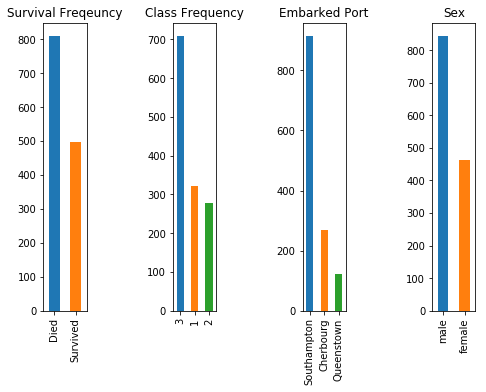

In [6]:
# Adjust subplot margins
plt.subplots_adjust(left=1, bottom=1, right=2, top=2, wspace=2, hspace=2)
plt.tight_layout()

# plot survial bar
plt.subplot(1, 4, 1)
df['Survived'].value_counts().plot(kind='bar')
plt.title('Survival Freqeuncy')
plt.xticks([0,1], ['Died','Survived'])

# plot passanger class bar
plt.subplot(1, 4, 2)
df['Pclass'].value_counts().plot(kind='bar')
plt.title('Class Frequency')

# plot port of embarkment bar
plt.subplot(1, 4, 3)
df['Embarked'].value_counts().plot(kind='bar')
plt.title('Embarked Port')
plt.xticks([0,1,2], ['Southampton', 'Cherbourg', 'Queenstown'])

# plot sex bar
plt.subplot(1, 4, 4)
df['Sex'].value_counts().plot(kind='bar')
plt.title('Sex')

The following can be observed:
* The majority of the passengers in the data did not seem to survive the accident according to the test and training data. 
* While the majority of passengers came as 3rd class, more 1st class passengers attended than 2nd class
* The absolute majority of passengers came from the Cherbourg port compared to the other two (more than double Queenstown).
* Significantly more males were in the ship the females (nearly double)

#### Numerical Data (Box Plots)

In [7]:
# plot a box plot of numeric fields only
boxDf = df[['Age','SibSp','Parch','Fare']]

# scale the data using a mapper
mapper = DataFrameMapper([(boxDf.columns, pre.StandardScaler())])
scaledFeatures = mapper.fit_transform(boxDf.copy(), len(boxDf.columns))
sBoxDf = pd.DataFrame(scaledFeatures, index=boxDf.index, columns=boxDf.columns)


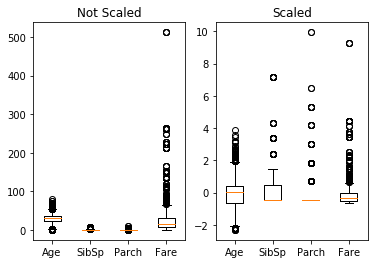

In [8]:
# plot not scaled
plt.subplot(1, 2, 1)
plt.boxplot([boxDf['Age'], boxDf['SibSp'], boxDf['Parch'], boxDf['Fare']])
plt.xticks([1, 2, 3, 4], ['Age','SibSp','Parch','Fare'])
plt.title('Not Scaled')

# plot scaled
plt.subplot(1, 2, 2)
plt.boxplot([sBoxDf['Age'], sBoxDf['SibSp'], sBoxDf['Parch'], sBoxDf['Fare']])
plt.xticks([1, 2, 3, 4], ['Age','SibSp','Parch','Fare'])
plt.title('Scaled')

plt.show()

The box plot of non categorical fields shows an issue with the scale variance between the different values. This scale difference makes it difficult to compare the data spread and location between different variables. Hence, scaling is necessary. 

Looking at the scaled data we can see that:
* Fare data is tightly clustered with a lot of outliers. This probably because the majority of fares are clustered together and the more luxurious fares are unpopular or too expensive 
* Age distribution seems to fairly well spread out, but with a couple of outliers at the highest ages.
* Number of parents or children abroad seems to average around 0 in the scale with little to no range, meaning that the average is very low and very common. The outliers for the high values suggests not many family came to the trip.
* The number of sibling or spouses seems to have a similar average than parents or children, but higher ranges and fewer outliers suggests that siblings/spouses number above the average are more common than families above the average.

## Methods

In [9]:
# Change categorical fields with strings to ints 
# for fitting

cTestDf['Sex'] = cTestDf['Sex'].replace(['female'],0)
cTestDf['Sex'] = cTestDf['Sex'].replace(['male'],1)

cTrainDf['Sex'] = cTrainDf['Sex'].replace(['female'],0)
cTrainDf['Sex'] = cTrainDf['Sex'].replace(['male'],1)

# Add new binary variables for 2 value embarked 
cTestDf['EmbarkedS'] = cTestDf['Embarked']
cTestDf['EmbarkedS'] = cTestDf['EmbarkedS'].replace(['S'],1)
cTestDf['EmbarkedS'] = cTestDf['EmbarkedS'].replace(['Q'],0)
cTestDf['EmbarkedS'] = cTestDf['EmbarkedS'].replace(['C'],0)

cTestDf['EmbarkedQ'] = cTestDf['Embarked']
cTestDf['EmbarkedQ'] = cTestDf['EmbarkedQ'].replace(['S'],0)
cTestDf['EmbarkedQ'] = cTestDf['EmbarkedQ'].replace(['Q'],1)
cTestDf['EmbarkedQ'] = cTestDf['EmbarkedQ'].replace(['C'],0)

cTrainDf['EmbarkedS'] = cTrainDf['Embarked']
cTrainDf['EmbarkedS'] = cTrainDf['EmbarkedS'].replace(['S'],1)
cTrainDf['EmbarkedS'] = cTrainDf['EmbarkedS'].replace(['Q'],0)
cTrainDf['EmbarkedS'] = cTrainDf['EmbarkedS'].replace(['C'],0)

cTrainDf['EmbarkedQ'] = cTrainDf['Embarked']
cTrainDf['EmbarkedQ'] = cTrainDf['EmbarkedQ'].replace(['S'],0)
cTrainDf['EmbarkedQ'] = cTrainDf['EmbarkedQ'].replace(['Q'],1)
cTrainDf['EmbarkedQ'] = cTrainDf['EmbarkedQ'].replace(['C'],0)

cTrainDf = cTrainDf.drop(columns=['Embarked']) # drop original, no longer needed
cTestDf = cTestDf.drop(columns=['Embarked']) # drop original, no longer needed

# separate predictors from response and scale predictors

testPred = cTestDf.loc[:, cTestDf.columns != 'Survived']
testRes = cTestDf['Survived']
trainPred = cTrainDf.loc[:, cTrainDf.columns != 'Survived']
trainRes = cTrainDf['Survived']

mapper = DataFrameMapper([(trainPred.columns, pre.StandardScaler())])
scaledFeatures = mapper.fit_transform(trainPred.copy(), len(trainPred.columns))
sTrainPred = pd.DataFrame(scaledFeatures, index=trainPred.index, columns=trainPred.columns)

mapper = DataFrameMapper([(testPred.columns, pre.StandardScaler())])
scaledFeatures = mapper.fit_transform(testPred.copy(), len(testPred.columns))
sTestPred = pd.DataFrame(scaledFeatures, index=testPred.index, columns=testPred.columns)

## print metrics (Accuracy, confusion, f1)
def printMetrics(prediction):
    print('accuracy', met.accuracy_score(testRes, prediction))
    print()
    print(met.confusion_matrix(testRes, prediction))
    print()
    print('f1', met.f1_score(testRes, prediction))
 
# Code adapted from https://github.com/yuguan1/example-ML-code
## tuning method (5 cv)
def tuning(function, parameters):
    print("# Tuning hyper-parameters")
    clf = GridSearchCV(function, parameters, cv=5)
    clf.fit(sTrainPred, trainRes)

    print('best parameters:')
    print(clf.best_params_)
    print('-------------------------------------')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    '''
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    '''

### Logistic Regression

Logistic Regression is a linear classification method. Logistic Regression is considered a supervised method because it takes in the data and predefined labels. 

To achieve its classification, Logistic Regression fits a line to separate the data into classes. The line is fitted by minimising the Mean Square Error (error between line and points) by changing the coefficients assigned to variables and the intercept. To minimise the error a method called gradient descent is used which updates the parameters (coefficients and intercepts) through the use to their partial derivative to find a local minimum/maximum.

Logistic regression finds the label by using a transformation function (e.g. sigmoid) to decide whether the points are in a particular class or not based on the value of the function.

In [10]:
# Fit and prediction
clf = LogisticRegression().fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

#### Coefficents Interpretation

In [11]:
# create table for coefs
coefs = pd.concat([pd.DataFrame(trainPred.columns),
                 pd.DataFrame(np.transpose(clf.coef_))],
                axis = 1)
coefs.loc[len(coefs)] = ['intercept', clf.intercept_[0]]
print(coefs) # print table

           0         0
0     Pclass -0.904127
1        Sex -1.272542
2        Age -0.515014
3      SibSp -0.355794
4      Parch -0.072713
5       Fare  0.099337
6  EmbarkedS -0.185054
7  EmbarkedQ -0.013494
8  intercept -0.649258


The coefficient can help in interpreting the effects of predictors on the prediction/response. The following observations can be made:
* Sex (encoded with 0 female and 1 male) is the strongest predictor, and is negative suggesting females had a higher survival rate than the other sex.
* Embarked predictors had a weak effect generally, suggest the port of embankment had little impact. The same can be observed with the fare.
* Other variables that were strong were Pclass1 (positive), Pclass3 (negative) and Age (negative). Suggests that younger people from 1st class had higher survival rates than older people and people in 3rd class.
* interestingly, spouses seem to have lower survival according to this model (negative) compares to families which had a very small negative coefficient (possible little impact).

#### Metrics

In [12]:
# Metrics (predtion vs Test response)
printMetrics(prediction)

accuracy 0.7697841726618705

[[216  43]
 [ 53 105]]

f1 0.6862745098039216


The model seems to have decent accuracy at 76.98 percent (correct to 2DP), but seems to mispredict more survival than mispredicting dead generally (which possibly led to a lower F1).

### Support Vector Machines ***rare events *** poor intr

Support Vector Machines help improve logistic regression by selecting the line with the largest margin to separate the two classes. To do this, support vector machines add two lines $(w ^ T + b) = 1$ and $(w ^ T + b) = -1$  (where $w$ is the vector of coefficients transposed and b is the intercept) to represent the margins. To find the maximum width, the line is varied (intercept and coefficient) to maximise (or minimise the inverse) the distances to the line but this time with the restriction that no points can be ahead of the margins of the line. To decide the points label, the sign of the function of the point is used. 

Support Vector Machines can have two types of margins:
* Hard: doesn't tolerate points outside of their margins (narrower)
* Soft: more tolerance for points outside their margins (wider)

The hardness of the margins is decided by variable C, which adds a penalty to the error of margins (larger C more penalty and harder).

To help interpreting non linear data, a kernel can be used to carry what is known as a "kernel trick", which essentially transforms the data to a higher dimension. There are various kernels that can be used, the most common is the Raidial Bias Function (RBF). RBF takes a gamma parameter which controls the variance or influence of the Support Vector Machine (the higher the gamma the lower the variance).

#### Hyperparameter Parameter Tuning 

In [13]:
# Set the parameters by cross-validation  ['linear', 'rbf', 'sigmoid','poly'],

parameters = [{'kernel': ['rbf'],
                'gamma': [1e-4, 0.01, 0.1, 0.5],
                'C': [1, 10, 100, 1000]}]

# Tune parameters using 5 fold cross validation 
tuning(SVC(), parameters)

# Tuning hyper-parameters
best parameters:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
-------------------------------------


To find the ideal parameters for the Support Vector Machine (C and gamma as stated before), k fold cross validation using the training data was carried where k = 5. In k fold cross validation the data is randomly divided into k folds, one fold is used as test data and the rest as training data. This interestingly will basically be used to train and test the model with different parameters with each set of parameters compared using accuracy (the parameters with the highest accuracy is chosen as ideal).

The results with 5 fold cross validation showed that the ideal C is 100 (hard and narrow margins) and a gamma of 0.01 (relatively small variance). 

#### Interpretation
Unfortunately, unlike logistic regression Support Vector Machine are more black box like due to their use of kernels and they are difficult to interpret when it comes to predictor influence. This is simply because unlike logistic regression, the kernel transformation of the data into higher dimensions makes it difficult to have specific coefficient values. Hence, we can only best assume that since this method is similar to logistic regression, most of the dominant predictors would be similar. 

In [14]:
# Fit and predict using optimal params from cv
optimalC = 100
optimalGamma = 0.01
clf.fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

#### Metrics

In [15]:
# Metrics (predtion vs Test response)
printMetrics(prediction)

accuracy 0.7697841726618705

[[216  43]
 [ 53 105]]

f1 0.6862745098039216


When the optimal values are selected (C = 100 and Gamma = 0.01) the accuracy of the Support Vector Machine model is slightly better than the logistic regression. However, the f1 score seems to have been slightly harmed as a result of this model picking even more mispredicted survivals than logistic regression, meaning that this model failed at fixing the main issue with the previous model.

### Decision Tree

Similarly to the logistic regression and the Support Vector Machines, Decision Trees are supervised learning method used for classification. Decision Trees make decisions about variables and their values in a tree by using the entropy to make sure the variables (branches) and variable values (internal node) with the most impact are in the higher tree levels. Each leaf node at the end of a part of the tree corresponds to a class label.

#### Hyper Parameter Training 

In [23]:
parameters = [{'max_depth': [4,6,8,10]}]

# Tune parameters using 5 fold cross validation 
tuning(DecisionTreeClassifier(), parameters)

# Tuning hyper-parameters
best parameters:
{'max_depth': 6}
-------------------------------------


When it comes to the parameters that control the decision tree, one important parameter is the max depth. The max depth restricts the depth of the tree and can be helpful is reducing over plotting (relate to variance). As usual, to select the best value for this parameter, k-fold cross validation with k = 5 for the training data is used which returns depth 6 (not too deep).

#### Interpretation 

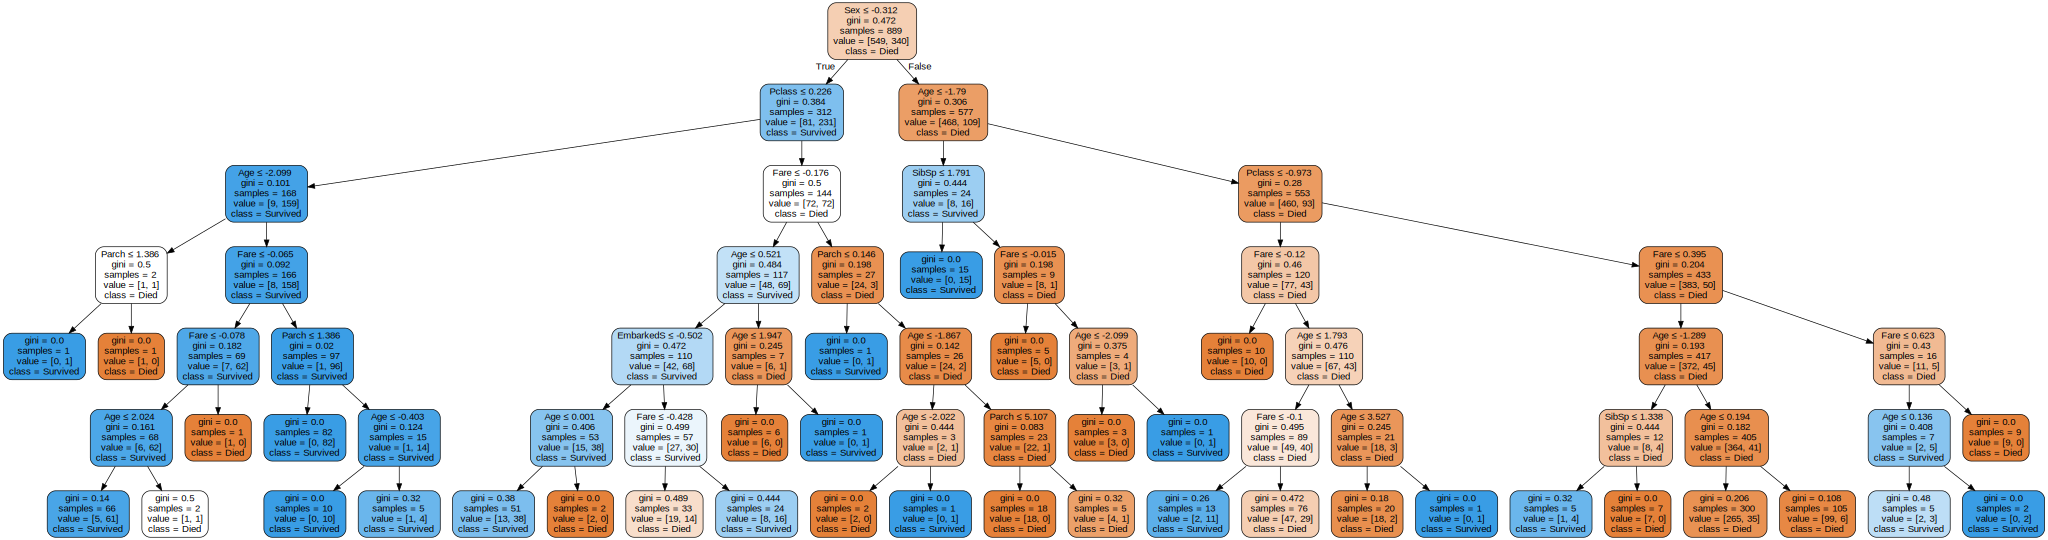

In [24]:
# fit and prediction
optimalDepth = 6

clf = DecisionTreeClassifier(max_depth = optimalDepth)
clf.fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

# Metrics (prediction vs Test response)


dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("BIG BOI") 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(sTrainPred.columns),  
                         class_names=['Died','Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

A good feature of decision tree is their easy interpretation, as the model can be easily represented using a tree with nodes. As previously stated, the nodes at the higher levels represent the most entropy, and we can see that separating the data by Sex, Passenger class and Age being at the top levels with lower ages, females (less than average which means closer to 0 label) and lower passenger class more likely to survive according to class labels.

#### Metrics

In [25]:
printMetrics(prediction)

accuracy 0.7577937649880095

[[219  40]
 [ 61  97]]

f1 0.6576271186440679


The results seems quite similar to other two models again, with slightly worse accuracy but the F1 score seemed to have been even more harmed than the previous two models, as this model once again mispredicts a lot of survivors. This could be due to the decision tree poor generalisation and its habit to overfit and perhaps a Random Forest will do better.

### Random Forest

The random attempts to solve one of the issues with the decision tree (overfitting and generalisation) via subsetting the data and creating multiple trees. The trends of these trees are then averaged out for the result.

#### Hyper Parameter Training 

In [19]:
parameters = [{'max_depth': [4,6,8,10],
               'n_estimators': [10,40,100,200]}]

# Tune parameters using 5 fold cross validation 
tuning(RandomForestClassifier(), parameters)

# Tuning hyper-parameters
best parameters:
{'max_depth': 8, 'n_estimators': 100}
-------------------------------------


The tuning is quite similar to the decision tree, we are again tuning the maximum depth using 5 k fold cross validation, but this time the number of trees (cuts overfitting for undefitting) is also included.

#### Interpretation

In [20]:
# fit and prediction
optimalDepth = 8
optimalEstimators = 100
# max_depth=3, n_estimators=20, max_features=1
clf = RandomForestClassifier(max_depth = optimalDepth, n_estimators = optimalEstimators)
clf.fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

importances = pd.concat([pd.DataFrame(sTrainPred.columns),
                         pd.DataFrame(np.transpose(clf.feature_importances_))],
                       axis = 1)
print(importances)

           0         0
0     Pclass  0.100574
1        Sex  0.303206
2        Age  0.215675
3      SibSp  0.057012
4      Parch  0.045239
5       Fare  0.240763
6  EmbarkedS  0.025406
7  EmbarkedQ  0.012126


Unlike the decision tree this method difficult to interpret since there are many trees to explore. So, instead the importances of the features is found using permutation and scrambling of features. We can see that while Sex and Age remain dominant, Fare also increased its dominance and the variables more balanced. The passenger class is no longer as dominant as it used to be. 

#### Metrics

In [26]:
# Metrics (predtion vs Test response)
printMetrics(prediction)

accuracy 0.7577937649880095

[[219  40]
 [ 61  97]]

f1 0.6576271186440679


Annoyingly, the metrics are nearly identical to the decision tree suggesting that there might be another factor effecting the results. 

## Conclusions

* Summarise results 
* Things to change
     - Linear kernels (coef and less complex)
     - Deep learning 
     - More data (rnd issues)